In [1]:
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import snowflake.connector
from snowflake.sqlalchemy import URL

In [14]:
data = pd.read_csv('data/hash_anomalies.csv')
data.head()

,HASH5,LOAN_ID,CLIENT_ID,LOANAMOUNT,DISBURSEMENTDATE,DISBURSED,DEFAULTED,DELAYED
0,ebzz6,HWHZ195,710681282,150.0,2024-10-13 15:10:13.000,1,0,0
1,ebzxk,HIXQ587,916325348,280.0,2024-10-13 15:52:36.000,1,0,1
2,s10je,JZGT130,909498167,150.0,2024-10-13 15:49:18.000,1,0,0
3,ecpb1,EIFO946,472425570,50.0,2024-10-13 15:20:44.000,1,0,0
4,ecxmk,CLEK471,122552537,280.0,2024-10-13 16:10:41.000,1,1,1


In [15]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83477 entries, 0 to 83476
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   HASH5             83477 non-null  object 
 1   LOAN_ID           83477 non-null  object 
 2   CLIENT_ID         83477 non-null  int64  
 3   LOANAMOUNT        83477 non-null  float64
 4   DISBURSEMENTDATE  83477 non-null  object 
 5   DISBURSED         83477 non-null  int64  
 6   DEFAULTED         83477 non-null  int64  
 7   DELAYED           83477 non-null  int64  
dtypes: float64(1), int64(4), object(3)
memory usage: 5.1+ MB


In [16]:
blocked = pd.read_csv('data/Blocked Hashes Ghana -Updated Dec30 - Sheet1 (1).csv')
blocked.head()

,hash_name,From_Date,To_Date,Ticket_Number
0,ecxq6,2023-08-24,2999-12-31,"DML-827, added 24.08.2023 ghana"
1,ecreb,2023-09-19,2999-12-31,"DML-871, added 19.09.2023"
2,ecqb8,2023-09-26,2999-12-31,"DML-882, added 26.09.2023"
3,ecn5r,2023-11-13,2999-12-31,"DML-977, added 13.11.2023"
4,ecn72,2023-11-13,2999-12-31,"DML-977, added 13.11.2023"


In [18]:
blocked.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39 entries, 0 to 38
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   hash_name       39 non-null     object
 1   From_Date       39 non-null     object
 2   To_Date         39 non-null     object
 3   Ticket_Number   39 non-null     object
dtypes: object(4)
memory usage: 1.3+ KB


In [20]:
blocked['From_Date'] = pd.to_datetime(blocked['From_Date '])

In [17]:
data['DISBURSEMENTDATE'] = pd.to_datetime(data['DISBURSEMENTDATE'])

In [27]:
df = data.merge(blocked[['hash_name','From_Date']], left_on = 'HASH5', right_on='hash_name', how = 'left')
df.head()

,HASH5,LOAN_ID,CLIENT_ID,LOANAMOUNT,DISBURSEMENTDATE,DISBURSED,DEFAULTED,DELAYED,hash_name,From_Date
0,ebzz6,HWHZ195,710681282,150.0,2024-10-13 15:10:13,1,0,0,NaN,NaT
1,ebzxk,HIXQ587,916325348,280.0,2024-10-13 15:52:36,1,0,1,NaN,NaT
2,s10je,JZGT130,909498167,150.0,2024-10-13 15:49:18,1,0,0,NaN,NaT
3,ecpb1,EIFO946,472425570,50.0,2024-10-13 15:20:44,1,0,0,NaN,NaT
4,ecxmk,CLEK471,122552537,280.0,2024-10-13 16:10:41,1,1,1,NaN,NaT


In [29]:
df['disb_week'] = df['DISBURSEMENTDATE'].dt.isocalendar().week

In [30]:
weekly_disb = df.groupby(['HASH5', 'disb_week']).agg(
    nloans = ('DISBURSED', sum),
    nlvalue = ('LOANAMOUNT', sum),
    ndr1s = ('DELAYED', sum) ,
    npfraud = ('DEFAULTED', sum)
)

/var/folders/br/rqk8kpt50q1_dkr0c2p_53lh0000gp/T/ipykernel_19855/846733587.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  weekly_disb = df.groupby(['HASH5', 'disb_week']).agg(
/var/folders/br/rqk8kpt50q1_dkr0c2p_53lh0000gp/T/ipykernel_19855/846733587.py:1: FutureWarning: The provided callable <built-in function sum> is currently using SeriesGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  weekly_disb = df.groupby(['HASH5', 'disb_week']).agg(


In [31]:
weekly_disb['disb_growth_rate'] = weekly_disb.groupby('HASH5')['nloans'].pct_change()
weekly_disb.head()

nloans  nlvalue  ndr1s  npfraud  disb_growth_rate
HASH5 disb_week                                                   
ebvuc 31              1    280.0      1        0               NaN
      35              2    430.0      1        0               1.0
ebvug 23              1    100.0      1        0               NaN
ebvuu 31              1    250.0      0        0               NaN
      36              1    280.0      1        0               0.0

In [ ]:
weekly_disb = weekly_disb.reset_index()

In [36]:
weekly_disb = weekly_disb.sort_values(by=['HASH5', 'disb_week']).reset_index(drop=True)
weekly_disb.head(10)

,HASH5,disb_week,nloans,nlvalue,ndr1s,npfraud,disb_growth_rate
0,ebvuc,31,1,280.0,1,0,NaN
1,ebvuc,35,2,430.0,1,0,1.0
2,ebvug,23,1,100.0,1,0,NaN
3,ebvuu,31,1,250.0,0,0,NaN
4,ebvuu,36,1,280.0,1,0,0.0
5,ebvuu,44,1,150.0,1,0,0.0
6,ebvuv,20,1,200.0,0,0,NaN
7,ebvuv,24,1,200.0,1,0,0.0
8,ebvuv,30,1,280.0,1,1,0.0
9,ebvuv,31,1,280.0,1,0,0.0


Finding the Correlation between DR1 & PCT CHANGE in Weekly Disbursements

In [37]:
weekly_disb['dr1'] = weekly_disb['ndr1s']/weekly_disb['nloans']

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

In [40]:
trendsdf = weekly_disb[~pd.isnull(weekly_disb['disb_growth_rate'])]

[]

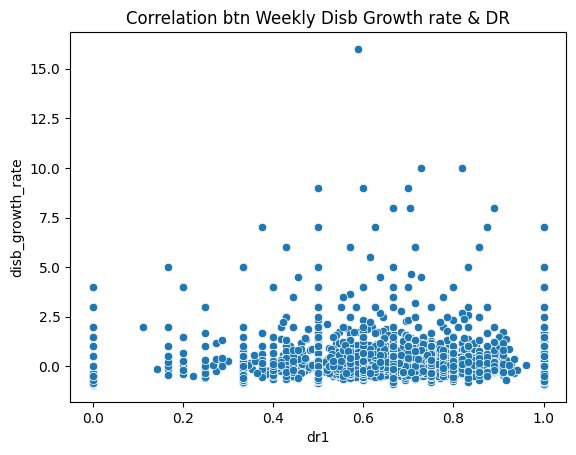

In [64]:
sns.scatterplot(data = trendsdf, x='dr1', y='disb_growth_rate')
plt.title('Correlation btn Weekly Disb Growth rate & DR')
plt.plot()

In [48]:
correlation_df = (
    weekly_disb.groupby('HASH5')[['dr1', 'disb_growth_rate']]
    .corr()
    .unstack()
    .iloc[:, 1]
    .reset_index()
)
correlation_df.columns = ['HASH5', 'correlation_coefficient']
correlation_df = correlation_df.reset_index(drop=True)
correlation_df = correlation_df.sort_values(by='correlation_coefficient').reset_index(drop=True)
correlation_df.head(20)

,HASH5,correlation_coefficient
0,ecpe9,-1.000000
1,s10rd,-1.000000
2,s1b5f,-1.000000
3,ebzrh,-1.000000
4,ecp77,-1.000000
5,ecpdt,-1.000000
6,ecwfn,-1.000000
7,ecw2v,-1.000000
8,ecrvr,-1.000000
9,ecrux,-1.000000


In [58]:
highcorr = correlation_df[correlation_df['correlation_coefficient']>0.4]

In [59]:
highcorr.head(20)

,HASH5,correlation_coefficient
836,ecps5,0.406336
837,ebzq9,0.407291
838,eby7s,0.407556
839,ecnst,0.408248
840,ebytd,0.408248
841,ecnfc,0.408248
842,ebzmt,0.408248
843,ecq9s,0.408248
844,ecpfq,0.409999
845,ebyzj,0.415831


In [60]:
highcorr_df = weekly_disb[weekly_disb['HASH5'].isin(highcorr['HASH5'])]
highcorr_df.head()

,HASH5,disb_week,nloans,nlvalue,ndr1s,npfraud,disb_growth_rate,dr1
33,ebvux,20,2,300.0,2,0,NaN,1.0
34,ebvux,25,1,150.0,0,0,-0.5,0.0
35,ebvux,29,1,150.0,0,0,0.0,0.0
36,ebvux,37,1,280.0,1,1,0.0,1.0
37,ebvux,47,1,280.0,1,0,0.0,1.0


[]

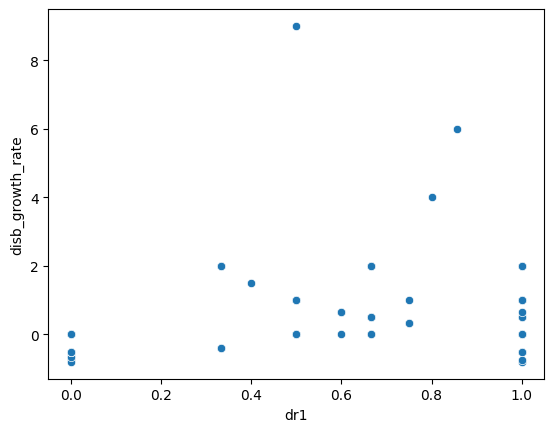

In [61]:
sns.scatterplot(data = highcorr_df, x='dr1', y='disb_growth_rate')
plt.plot()

In [63]:
highcorr_df['HASH5'].nunique()

83

k2w